#Graph

In [ ]:
# Install required packages
!pip install torch_geometric imbalanced-learn

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.manifold import TSNE

In [ ]:
# Download Dataset
dataset_dir = kagglehub.dataset_download("ealaxi/banksim1")

# Find the CSV file within the directory
for filename in os.listdir(dataset_dir):
    if filename == "bs140513_032310.csv":
        file_path = os.path.join(dataset_dir, filename)
        break
else:
    raise FileNotFoundError("No CSV file found in the dataset directory.")

# Read the CSV file, specifying encoding
#data = pd.read_csv(file_path).sample(n=100000, random_state=42)
df = pd.read_csv(file_path)

In [ ]:
# 1. Load and preprocess data

features = df[["step", "age", "amount"]].copy()
features['age'] = pd.to_numeric(features['age'].astype(str).str.strip("'"), errors='coerce')
features.dropna(inplace=True)
labels = df.loc[features.index, "fraud"].values

X, _, y, _ = train_test_split(features, labels, stratify=labels, train_size=10000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

def create_knn_graph(X, y, k=10):
    edge_index = kneighbors_graph(X, k, mode='connectivity', include_self=False).nonzero()
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

train_data = create_knn_graph(X_train, y_train, k=10)
test_data = create_knn_graph(X_test, y_test, k=10)

Graph visualization

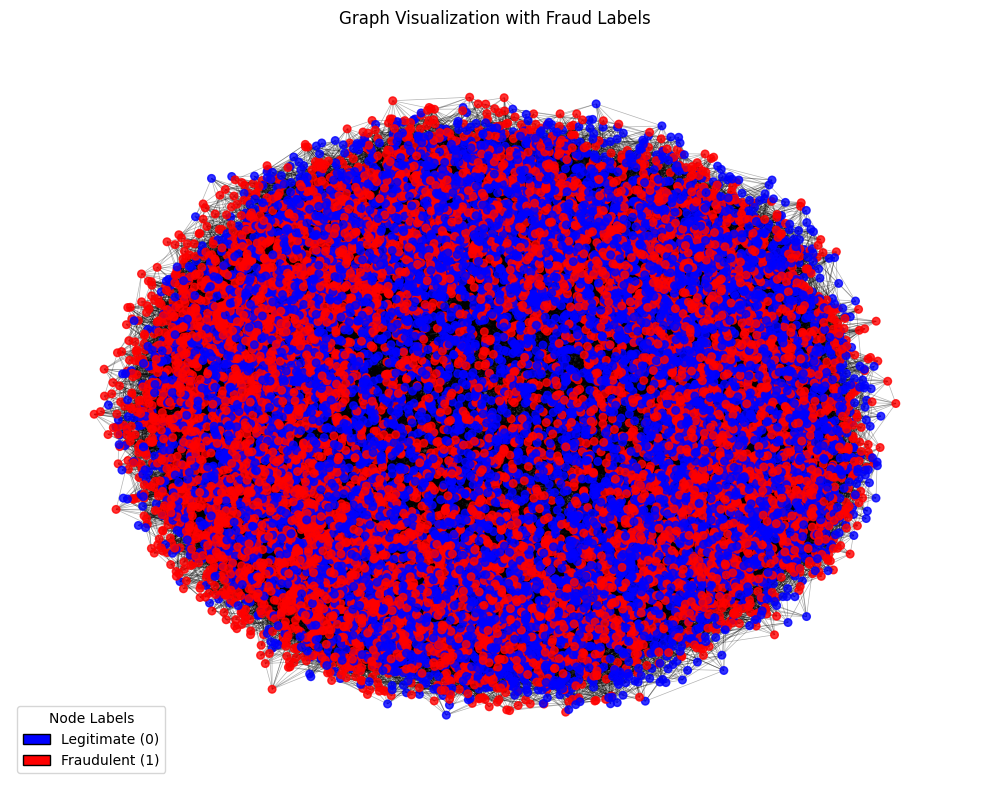

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert to NetworkX graph (undirected for visualization)
G = to_networkx(train_data, to_undirected=True)

# Node colors by label
node_labels = train_data.y.numpy()
node_colors = ['red' if label == 1 else 'blue' for label in node_labels]

# Create spring layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.1)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', edgecolor='k', label='Legitimate (0)'),
    Patch(facecolor='red', edgecolor='k', label='Fraudulent (1)')
]
plt.legend(handles=legend_elements, title='Node Labels', loc='lower left')

# Optional: add node labels (if graph is small)
# label_dict = {i: str(train_data.y[i].item()) for i in range(len(train_data.y))}
# nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=6)

plt.title("Graph Visualization with Fraud Labels")
plt.axis("off")
plt.tight_layout()
plt.show()


#GraphSAGE

In [ ]:
from torch_geometric.nn import SAGEConv

# 2. Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(num_features, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim // 2)
        self.out = torch.nn.Linear(hidden_dim // 2, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.sage1(x, edge_index))
        x = F.relu(self.sage2(x, edge_index))
        return self.out(x)

In [ ]:
# 3. Grid Search (with training progress)
learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [16, 32, 64]
best_model = None
best_f1 = 0
best_config = {}

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        print(f"\n🔍 Testing config: LR={lr}, Hidden={hidden_dim}")
        model = GraphSAGE(train_data.num_features, hidden_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        # 4. Train the model (fast and memory-efficient)
        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(train_data.x, train_data.edge_index)
            loss = criterion(out, train_data.y)
            loss.backward()
            optimizer.step()
            #print(f"Epoch {epoch+10}, Loss: {loss.item():.4f}")
            # Print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Evaluate
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, test_data.edge_index)
            probs = F.softmax(logits, dim=1)[:, 1].detach().numpy()

        # Threshold sweep
        thresholds = torch.linspace(0, 1, 100)
        for thresh in thresholds:
            preds = (probs >= thresh.item()).astype(int)
            f1 = f1_score(y_test, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_config = {"lr": lr, "hidden_dim": hidden_dim, "threshold": thresh.item()}



🔍 Testing config: LR=0.001, Hidden=16
Epoch 10, Loss: 0.6996
Epoch 20, Loss: 0.6294
Epoch 30, Loss: 0.5750
Epoch 40, Loss: 0.5343
Epoch 50, Loss: 0.5008

🔍 Testing config: LR=0.001, Hidden=32
Epoch 10, Loss: 0.6421
Epoch 20, Loss: 0.5589
Epoch 30, Loss: 0.4848
Epoch 40, Loss: 0.4169
Epoch 50, Loss: 0.3591

🔍 Testing config: LR=0.001, Hidden=64
Epoch 10, Loss: 0.4504
Epoch 20, Loss: 0.3229
Epoch 30, Loss: 0.2544
Epoch 40, Loss: 0.2200
Epoch 50, Loss: 0.2042

🔍 Testing config: LR=0.005, Hidden=16
Epoch 10, Loss: 0.5002
Epoch 20, Loss: 0.3470
Epoch 30, Loss: 0.2607
Epoch 40, Loss: 0.2167
Epoch 50, Loss: 0.1980

🔍 Testing config: LR=0.005, Hidden=32
Epoch 10, Loss: 0.3291
Epoch 20, Loss: 0.2265
Epoch 30, Loss: 0.1995
Epoch 40, Loss: 0.1883
Epoch 50, Loss: 0.1807

🔍 Testing config: LR=0.005, Hidden=64
Epoch 10, Loss: 0.2150
Epoch 20, Loss: 0.2015
Epoch 30, Loss: 0.1836
Epoch 40, Loss: 0.1749
Epoch 50, Loss: 0.1684

🔍 Testing config: LR=0.01, Hidden=16
Epoch 10, Loss: 0.4557
Epoch 20, Loss:

In [ ]:
# 5. Final Evaluation
print(f"\n✅ Best Config: {best_config}")
with torch.no_grad():
    final_probs = F.softmax(best_model(test_data.x, test_data.edge_index), dim=1)[:, 1].detach().numpy()
final_preds = (final_probs >= best_config["threshold"]).astype(int)


acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds, zero_division=0)
rec = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
roc = roc_auc_score(y_test, final_probs)

print(f"\n📊 Final Metrics (threshold = {best_config['threshold']:.2f})")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")


✅ Best Config: {'lr': 0.01, 'hidden_dim': 32, 'threshold': 0.3737373650074005}

📊 Final Metrics (threshold = 0.37)
Accuracy : 0.9378
Precision: 0.9454
Recall   : 0.9291
F1 Score : 0.9372
ROC AUC  : 0.9813


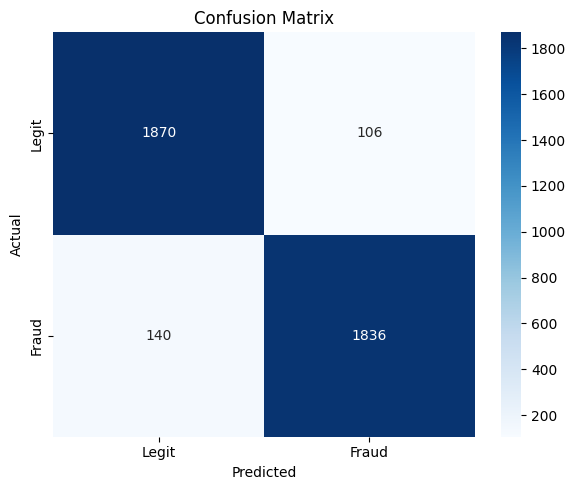

In [ ]:
from sklearn.metrics import confusion_matrix # Import the confusion_matrix function
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

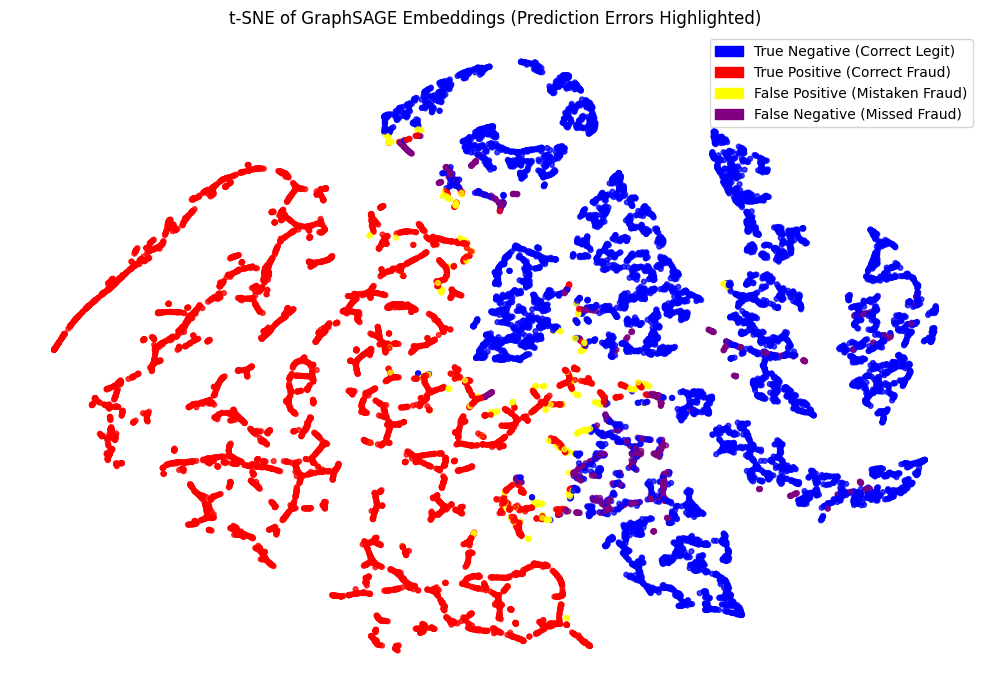

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Evaluate on training data
model.eval()
with torch.no_grad():
    # Get embeddings from hidden layers
    h1 = model.sage1(train_data.x, train_data.edge_index)
    h2 = model.sage2(F.relu(h1), train_data.edge_index)
    x_embed = h2.detach().numpy()

    # Get predictions from model
    logits = model(train_data.x, train_data.edge_index)
    probs = F.softmax(logits, dim=1)[:, 1]
    threshold = 0.5  # or your best threshold
    pred_labels = (probs >= threshold).int().numpy()

# True labels
true_labels = train_data.y.numpy()

# Assign color based on prediction vs truth
colors = []
for true, pred in zip(true_labels, pred_labels):
    if true == 0 and pred == 0:
        colors.append('blue')     # True Negative
    elif true == 1 and pred == 1:
        colors.append('red')      # True Positive
    elif true == 0 and pred == 1:
        colors.append('yellow')   # False Positive
    elif true == 1 and pred == 0:
        colors.append('purple')   # False Negative

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_embed)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=colors, s=12, alpha=0.75)
plt.title("t-SNE of GraphSAGE Embeddings (Prediction Errors Highlighted)")
plt.axis("off")

# Add custom legend
legend_elements = [
    Patch(color='blue', label='True Negative (Correct Legit)'),
    Patch(color='red', label='True Positive (Correct Fraud)'),
    Patch(color='yellow', label='False Positive (Mistaken Fraud)'),
    Patch(color='purple', label='False Negative (Missed Fraud)')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()


#GAT

In [ ]:
from torch_geometric.nn import GATConv

# 2. Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(num_features, hidden_dim, heads=2, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim // 2, heads=1, concat=True, dropout=0.2)
        self.out = torch.nn.Linear(hidden_dim // 2, 2)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        return self.out(x)

In [ ]:
# 3. Grid Search
learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [16, 32, 64]
best_model = None
best_f1 = 0
best_config = {}

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        print(f"\n🔍 Testing config: LR={lr}, Hidden={hidden_dim}")
        model = GAT(train_data.num_features, hidden_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

 # 4. Train the model (with loss logging)
        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(train_data.x, train_data.edge_index)
            loss = criterion(out, train_data.y)
            loss.backward()
            optimizer.step()
            #print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
            # Print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Evaluate
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, test_data.edge_index)
            probs = F.softmax(logits, dim=1)[:, 1].detach().numpy()

        # Threshold sweep
        thresholds = torch.linspace(0, 1, 100)
        for thresh in thresholds:
            preds = (probs >= thresh.item()).astype(int)
            f1 = f1_score(y_test, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_config = {
                    "lr": lr,
                    "hidden_dim": hidden_dim,
                    "threshold": thresh.item()
                }


🔍 Testing config: LR=0.001, Hidden=16
Epoch 10, Loss: 0.5630
Epoch 20, Loss: 0.4984
Epoch 30, Loss: 0.4465
Epoch 40, Loss: 0.4037
Epoch 50, Loss: 0.3669

🔍 Testing config: LR=0.001, Hidden=32
Epoch 10, Loss: 0.6779
Epoch 20, Loss: 0.5200
Epoch 30, Loss: 0.4589
Epoch 40, Loss: 0.4144
Epoch 50, Loss: 0.3766

🔍 Testing config: LR=0.001, Hidden=64
Epoch 10, Loss: 0.4685
Epoch 20, Loss: 0.3767
Epoch 30, Loss: 0.3136
Epoch 40, Loss: 0.2653
Epoch 50, Loss: 0.2341

🔍 Testing config: LR=0.005, Hidden=16
Epoch 10, Loss: 0.4605
Epoch 20, Loss: 0.3087
Epoch 30, Loss: 0.2281
Epoch 40, Loss: 0.2130
Epoch 50, Loss: 0.2103

🔍 Testing config: LR=0.005, Hidden=32
Epoch 10, Loss: 0.3532
Epoch 20, Loss: 0.2229
Epoch 30, Loss: 0.2138
Epoch 40, Loss: 0.2108
Epoch 50, Loss: 0.2073

🔍 Testing config: LR=0.005, Hidden=64
Epoch 10, Loss: 0.2617
Epoch 20, Loss: 0.2269
Epoch 30, Loss: 0.2111
Epoch 40, Loss: 0.2074
Epoch 50, Loss: 0.2049

🔍 Testing config: LR=0.01, Hidden=16
Epoch 10, Loss: 0.3245
Epoch 20, Loss:

In [ ]:
# 5. Final Evaluation
print(f"\n✅ Best Config: {best_config}")
with torch.no_grad():
    final_probs = F.softmax(best_model(test_data.x, test_data.edge_index), dim=1)[:, 1].detach().numpy()
final_preds = (final_probs >= best_config["threshold"]).astype(int)

acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds, zero_division=0)
rec = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
roc = roc_auc_score(y_test, final_probs)

print(f"\n📊 Final Metrics (threshold = {best_config['threshold']:.2f})")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")


✅ Best Config: {'lr': 0.01, 'hidden_dim': 16, 'threshold': 0.31313130259513855}

📊 Final Metrics (threshold = 0.31)
Accuracy : 0.9345
Precision: 0.9559
Recall   : 0.9109
F1 Score : 0.9329
ROC AUC  : 0.9729


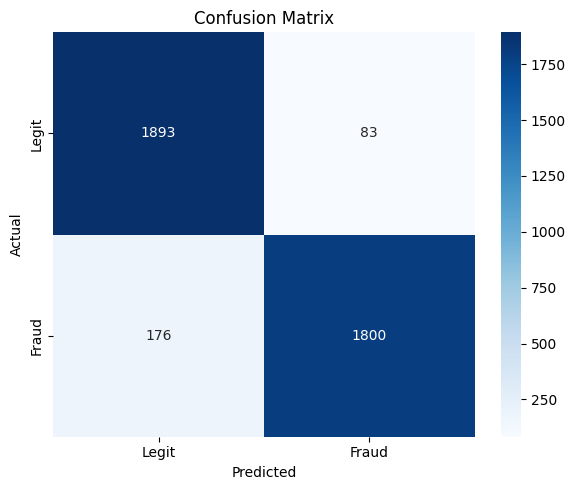

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

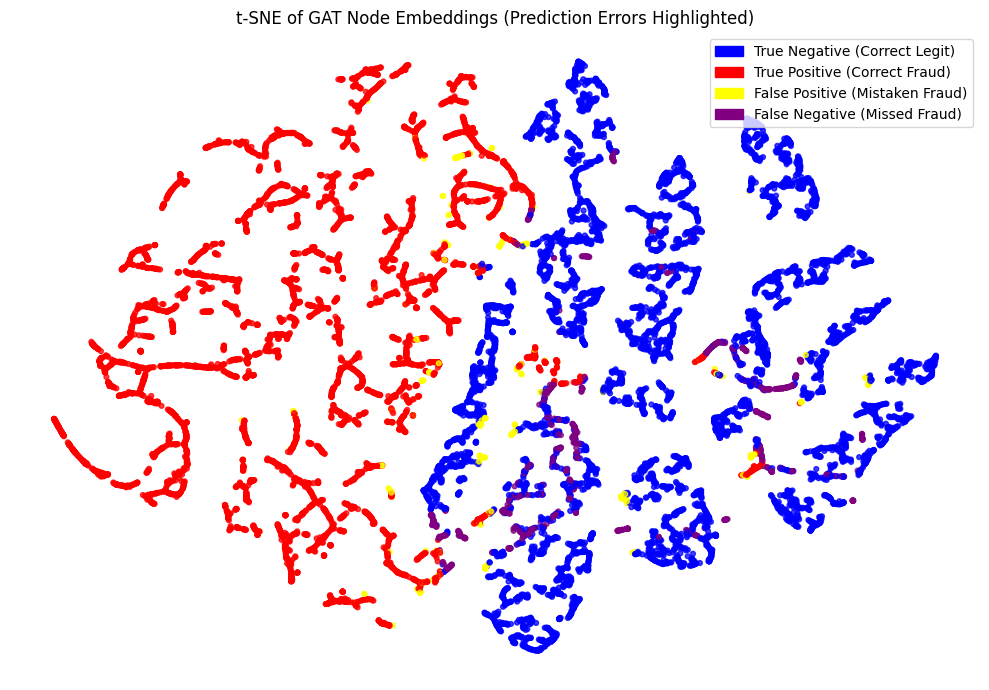

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Evaluate GAT model on training data
model.eval()
with torch.no_grad():
    # Get embeddings from hidden layers
    h1 = model.gat1(train_data.x, train_data.edge_index)
    h2 = model.gat2(F.elu(h1), train_data.edge_index)
    x_embed = h2.detach().numpy()

    # Get predictions from model
    logits = model(train_data.x, train_data.edge_index)
    probs = F.softmax(logits, dim=1)[:, 1]
    threshold = 0.5  # Or use your optimized threshold
    pred_labels = (probs >= threshold).int().numpy()

# True labels
true_labels = train_data.y.numpy()

# Assign color based on prediction vs truth
colors = []
for true, pred in zip(true_labels, pred_labels):
    if true == 0 and pred == 0:
        colors.append('blue')     # True Negative
    elif true == 1 and pred == 1:
        colors.append('red')      # True Positive
    elif true == 0 and pred == 1:
        colors.append('yellow')   # False Positive
    elif true == 1 and pred == 0:
        colors.append('purple')   # False Negative

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_embed)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=colors, s=12, alpha=0.75)
plt.title("t-SNE of GAT Node Embeddings (Prediction Errors Highlighted)")
plt.axis("off")

# Custom legend
legend_elements = [
    Patch(color='blue', label='True Negative (Correct Legit)'),
    Patch(color='red', label='True Positive (Correct Fraud)'),
    Patch(color='yellow', label='False Positive (Mistaken Fraud)'),
    Patch(color='purple', label='False Negative (Missed Fraud)')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()


#GCN

In [ ]:
from torch_geometric.nn import GCNConv
# 2. Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.out = torch.nn.Linear(hidden_dim // 2, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.out(x)

In [ ]:
# 3. Grid Search
learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [16, 32, 64]
best_model = None
best_f1 = 0
best_config = {}

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        print(f"\n🔍 Testing config: LR={lr}, Hidden={hidden_dim}")
        model = GCN(train_data.num_features, hidden_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        # 4. Train the model (with training logs)
        model.train()
        for epoch in range(20):
            optimizer.zero_grad()
            out = model(train_data.x, train_data.edge_index)
            loss = criterion(out, train_data.y)
            loss.backward()
            optimizer.step()
            #print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
            # Print loss every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, test_data.edge_index)
            probs = F.softmax(logits, dim=1)[:, 1].detach().numpy()

        # Threshold sweep
        thresholds = torch.linspace(0, 1, 100)
        for thresh in thresholds:
            preds = (probs >= thresh.item()).astype(int)
            f1 = f1_score(y_test, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_config = {
                    "lr": lr,
                    "hidden_dim": hidden_dim,
                    "threshold": thresh.item()
                }


🔍 Testing config: LR=0.001, Hidden=16
Epoch 10, Loss: 0.8517
Epoch 20, Loss: 0.7853

🔍 Testing config: LR=0.001, Hidden=32
Epoch 10, Loss: 0.7665
Epoch 20, Loss: 0.6655

🔍 Testing config: LR=0.001, Hidden=64
Epoch 10, Loss: 0.8287
Epoch 20, Loss: 0.6061

🔍 Testing config: LR=0.005, Hidden=16
Epoch 10, Loss: 0.5290
Epoch 20, Loss: 0.4084

🔍 Testing config: LR=0.005, Hidden=32
Epoch 10, Loss: 0.5105
Epoch 20, Loss: 0.3434

🔍 Testing config: LR=0.005, Hidden=64
Epoch 10, Loss: 0.3615
Epoch 20, Loss: 0.2173

🔍 Testing config: LR=0.01, Hidden=16
Epoch 10, Loss: 0.4854
Epoch 20, Loss: 0.3273

🔍 Testing config: LR=0.01, Hidden=32
Epoch 10, Loss: 0.3011
Epoch 20, Loss: 0.2098

🔍 Testing config: LR=0.01, Hidden=64
Epoch 10, Loss: 0.2471
Epoch 20, Loss: 0.2139


In [ ]:
# 5. Final Evaluation
print(f"\n✅ Best Config: {best_config}")
with torch.no_grad():
    final_probs = F.softmax(best_model(test_data.x, test_data.edge_index), dim=1)[:, 1].detach().numpy()
final_preds = (final_probs >= best_config["threshold"]).astype(int)

acc = accuracy_score(y_test, final_preds)
prec = precision_score(y_test, final_preds, zero_division=0)
rec = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
roc = roc_auc_score(y_test, final_probs)

print(f"\n📊 Final Metrics (threshold = {best_config['threshold']:.2f})")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")




✅ Best Config: {'lr': 0.01, 'hidden_dim': 32, 'threshold': 0.3737373650074005}

📊 Final Metrics (threshold = 0.37)
Accuracy : 0.9286
Precision: 0.9463
Recall   : 0.9089
F1 Score : 0.9272
ROC AUC  : 0.9732


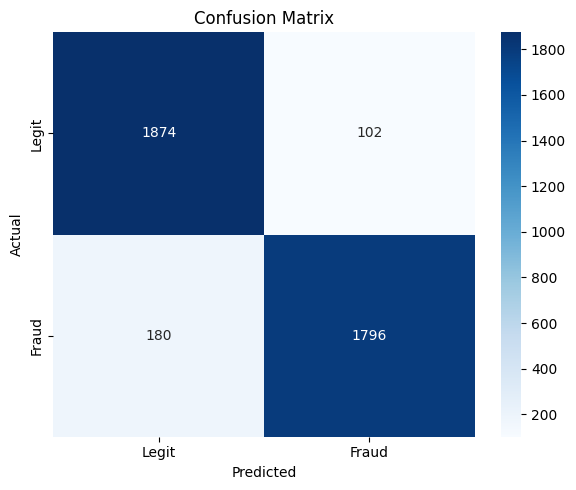

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

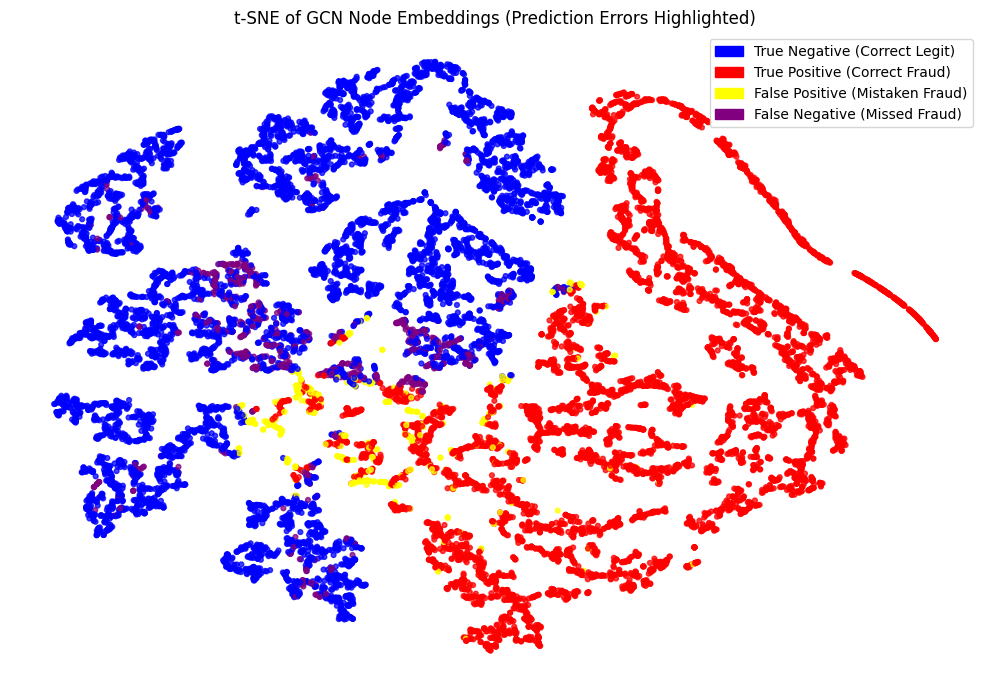

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Evaluate trained GCN model on training data
model.eval()
with torch.no_grad():
    # Get node embeddings from last hidden layer
    h1 = model.conv1(train_data.x, train_data.edge_index)
    h2 = model.conv2(F.relu(h1), train_data.edge_index)
    x_embed = h2.detach().numpy()

    # Get model predictions
    logits = model(train_data.x, train_data.edge_index)
    probs = F.softmax(logits, dim=1)[:, 1]
    threshold = 0.5  # Or use your best threshold
    pred_labels = (probs >= threshold).int().numpy()

# True labels
true_labels = train_data.y.numpy()

# Assign colors for error types
colors = []
for true, pred in zip(true_labels, pred_labels):
    if true == 0 and pred == 0:
        colors.append('blue')     # True Negative
    elif true == 1 and pred == 1:
        colors.append('red')      # True Positive
    elif true == 0 and pred == 1:
        colors.append('yellow')   # False Positive
    elif true == 1 and pred == 0:
        colors.append('purple')   # False Negative

# t-SNE projection to 2D
tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_embed)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=colors, s=12, alpha=0.75)
plt.title("t-SNE of GCN Node Embeddings (Prediction Errors Highlighted)")
plt.axis("off")

# Legend
legend_elements = [
    Patch(color='blue', label='True Negative (Correct Legit)'),
    Patch(color='red', label='True Positive (Correct Fraud)'),
    Patch(color='yellow', label='False Positive (Mistaken Fraud)'),
    Patch(color='purple', label='False Negative (Missed Fraud)')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()
